# Time Series Analysis - Forecasting Corporation Favorita stores Sales

## 1.Business Understanding
#### Objective:
To develop a predictive model for store sales for Corporation Favorita, a large grocery retailer headquartered in Ecuador. The model aims to predict the unit sales of numerous items across various Favorita stores, enabling more precise estimation of sales performance.

## 2.Data Understanding
For this project, we will use  several datasets.The training data includes dates, store, and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models


#### File Descriptions and Data Field Information
**Train.csv**
* The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
* `store_nbr` identifies the store at which the products are sold.
* `family` identifies the type of product sold.
* `sales` gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* `onpromotion` gives the total number of items in a product family that were being promoted at a store at a given date.

**Test.csv**
* The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
* The dates in the test data are for the 15 days after the last date in the training data.

**Transaction.csv**
* Contains date, store_nbr and transaction made on that specific date.

**Stores.csv**
* Stores metadata, including city, state, type, and cluster.
* Cluster is a grouping of similar stores.

**Oil.csv**
* Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

**Holidays_events.csv**
* Holidays and Events, with metadata


NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).
Additional Notes

Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthqua








#### Import packages 

In [117]:
# Data Handling
import pyodbc
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy import stats
from dotenv import dotenv_values


# Statistical Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ttest_ind
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
from matplotlib.dates import MonthLocator


# Other Packages
import warnings

warnings.filterwarnings("ignore")

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

#### Data Acquistion

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("database")
server = environment_variables.get("server")
username = environment_variables.get("user")
password = environment_variables.get("password")


connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"



In [3]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection = pyodbc.connect(connection_string)

In [4]:
# Define SQL queries for each table
query1 = 'SELECT * FROM dbo.oil'
query2 = 'SELECT * FROM dbo.holidays_events'
query3 = 'SELECT * FROM dbo.stores'

# Read data from tables into pandas DataFrames
oil = pd.read_sql(query1, connection)
holidays_events = pd.read_sql(query2, connection)
stores = pd.read_sql(query3, connection)

# Close the database connection
connection.close()

In [5]:
#Reading data from other sources
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
transactions = pd.read_csv('./data/transactions.csv')

**Previewing datasets**

In [6]:
# View the first 5 rows of the oil dataset
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [7]:
# View the first 5 rows of the holiday dataset
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
# View the first 5 rows of the stores dataset 
stores.head()


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
# View the first 5 rows of the train dataset
train.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [10]:
# View the first 5 rows of the test dataset
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [11]:
# View the first 5 rows of the transactions dataset
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [12]:
# Function to get more information about each dataset

def get_info(df: pd.DataFrame):
    print('============ Shape ============')
    print(df.shape)
    print('============ Data Types ============')
    print(df.info())
    print('============ Missing Values ============')
    print(df.isnull().sum())
    print('============ Duplicated Values ============')
    print(df.duplicated().sum())

In [13]:
#More information on oil dataset
get_info(oil)

============ Shape ============
(1218, 2)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None
============ Missing Values ============
date           0
dcoilwtico    43
dtype: int64
============ Duplicated Values ============
0


In [14]:
#More information on holidays dataset
get_info(holidays_events)

============ Shape ============
(350, 6)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None
============ Missing Values ============
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
============ Duplicated Values ============
0


In [15]:
#More information on stores dataset
get_info(stores)

============ Shape ============
(54, 5)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None
============ Missing Values ============
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
============ Duplicated Values ============
0


In [16]:
#More information on train dataset
get_info(train)

============ Shape ============
(3000888, 6)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None
============ Missing Values ============
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
============ Duplicated Values ============
0


In [17]:
#More information on test dataset
get_info(test)

============ Shape ============
(28512, 5)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None
============ Missing Values ============
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
============ Duplicated Values ============
0


In [18]:
#More information on transactions dataset
get_info(transactions)

============ Shape ============
(83488, 3)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
None
============ Missing Values ============
date            0
store_nbr       0
transactions    0
dtype: int64
============ Duplicated Values ============
0


Summary :
* In all the datasets, date is in object data type
* Only oil dataset has missing values(43)
* No duplicates in the datsets

## Hypotheses for testing:
Hypothesis 1: <br>
```Null```: The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.<br>
```Alternate```: The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

Hypothesis 2: <br>
```Null```: Sales dont increase over time. <br>
```Alternate```: Sales increase with time.

Hypothesis 3: <br>
```Null```: Situating a startup in a particular city does not influence funding.<br>
```Alternate```: Situating a startup in a particular city significantly affects funding.

Hypothesis 4: <br>
```Null```: Transactions don't have an impact on sales. <br>
```Alternate```: The more the transactions the higher the sales.

## Research Questions:

1. Is the train dataset complete (has all the required dates)?
2.  Which dates have the lowest and highest sales for each year?
3. Did the earthquake impact sales?
4. Are certain groups of stores selling more products? (Cluster, city, state, type)
5. What is the relationship between oil prices and store sales? 
6.  Do holidays and events influence store sales? Are there specific holidays/events that drive higher sales?
7. Is there a significant difference in sales by location and by store type?
8. Which store has the highest average sales, and which one has the lowest?

## 3. Data cleaning
#### Renaming columns


 <div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <h4 style="padding: 15px;
              color:black;">📌 Renaming the 'type' in holiday data to 'holiday type'
    </h4>
  </div>

This will enable merging between the oil dataset on the ```type``` column  and holiday dataset

In [19]:
# Rename the 'type' column to 'holiday_type'
holidays_events.rename(columns={'type': 'holiday_type'}, inplace=True)

# Print the resulting DataFrame
holidays_events

,date,holiday_type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [20]:
# Check for rows in train data whose sales is 770 and store number is 25
# This is to confirm if sales is same as transactions.
train[(train['sales'] == 770) & (train['store_nbr'] == 25) ] 

,id,date,store_nbr,family,sales,onpromotion
250053,250053,2013-05-21,25,GROCERY I,770.0,0
417552,417552,2013-08-23,25,BEVERAGES,770.0,0
631396,631396,2013-12-21,25,CLEANING,770.0,0


...

#### Merging datasets
* Join transcations and trains data to form full transactions dataframe

In [21]:
# Merge the 'transactions' DataFrame with the 'train' DataFrame
# This combines the data from both DataFrames based on their common columns, creating a new DataFrame named 'full_transaction'
# full_transaction = pd.merge(transactions, train)

# Display a random sample of 5 rows from the 'full_transaction' DataFrame
# The 'sample()' function is used to extract a random subset of rows from the DataFrame for inspectionctions
# full_transaction.sample(5)

Join the full transactions and stores based on store_number

In [22]:
# Merge the 'full_transaction' DataFrame with the 'sotres' DataFrame
# This combines the data based on the 'sote_nbr' column, using an 'inner' join type
# The result is a new DataFrame named 'result'
result = pd.merge( train, stores, on='store_nbr', how='inner')
result.head(5)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


Join the previously merged dataset and oil data based on date

In [23]:
# Merge the 'result' DataFrame with the 'oil' DataFrame
# This combines the data based on the 'date' column, using an 'inner' join type
# The result is a new DataFrame named 'result1'

result1= pd.merge(result, oil, on='date', how='inner')
result1.sample(5)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
382216,535468,2013-10-28,33,EGGS,149.000,0,Quevedo,Los Rios,C,3,98.739998
2081941,2914135,2017-06-28,25,BOOKS,0.000,0,Salinas,Santa Elena,D,1,44.740002
1550272,2170408,2016-05-05,7,SCHOOL AND OFFICE SUPPLIES,1.000,0,Quito,Pichincha,D,8,44.330002
622025,871505,2014-05-06,12,DAIRY,305.000,0,Latacunga,Cotopaxi,C,15,99.809998
839016,1174032,2014-10-22,5,MEATS,290.934,3,Santo Domingo,Santo Domingo de los Tsachilas,D,4,80.519997


Join the result dataframe and holidays data based on date

In [24]:
# Merge the 'result1' DataFrame with the 'holidays_events' DataFrame
# This combines the data based on the 'date' column, using an 'inner' join type
# The result is a new DataFrame named 'salesdata'


salesdata= pd.merge(result1, holidays_events, on='date')

# Reset the index of the 'salesdata' DataFrame
# The 'drop=True' parameter removes the current index, and 'inplace=True' applies the change directly to the DataFrame
salesdata.reset_index(drop=True,inplace=True)
salesdata.head(5)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


#### Rename columns

In [25]:
# Rename store_nbr as store_number amd dcpo;wtocp as oil_prices

salesdata.rename(columns={
    'store_nbr': 'store_number',
    'dcoilwtico': 'oil_prices',
}, inplace=True)
salesdata.sample(5)

,id,date,store_number,family,sales,onpromotion,city,state,type,cluster,oil_prices,holiday_type,locale,locale_name,description,transferred
42947,561509,2013-11-12,14,HARDWARE,0.000,0,Riobamba,Chimborazo,C,7,93.120003,Holiday,Local,Ambato,Independencia de Ambato,False
242054,2155922,2016-04-27,5,SEAFOOD,5.554,0,Santo Domingo,Santo Domingo de los Tsachilas,D,4,45.290001,Event,National,Ecuador,Terremoto Manabi+11,False
176111,1683683,2015-08-05,5,MAGAZINES,2.000,0,Santo Domingo,Santo Domingo de los Tsachilas,D,4,45.130001,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
175242,1682814,2015-08-05,26,GROCERY I,1295.000,14,Guayaquil,Guayas,D,10,45.130001,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
60023,760349,2014-03-04,42,PREPARED FOODS,0.000,0,Cuenca,Azuay,D,2,103.639999,Holiday,National,Ecuador,Carnaval,False


In [26]:
salesdata.columns  # Get the column names of the salesdata

Index(['id', 'date', 'store_number', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'oil_prices', 'holiday_type', 'locale',
       'locale_name', 'description', 'transferred'],
      dtype='object')

In [27]:
salesdata = salesdata[['id','date',  'store_number', 'family', 'sales',
       'onpromotion', 'city', 'state', 'type', 'cluster', 'oil_prices',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred']]   # Rearrange columns of the data

In [28]:
salesdata.head()   # Get first 5 rows

,id,date,store_number,family,sales,onpromotion,city,state,type,cluster,oil_prices,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [29]:
#Using the get_info function to get information on merged dataset
get_info(salesdata)

============ Shape ============
(352836, 16)
============ Data Types ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352836 entries, 0 to 352835
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            352836 non-null  int64  
 1   date          352836 non-null  object 
 2   store_number  352836 non-null  int64  
 3   family        352836 non-null  object 
 4   sales         352836 non-null  float64
 5   onpromotion   352836 non-null  int64  
 6   city          352836 non-null  object 
 7   state         352836 non-null  object 
 8   type          352836 non-null  object 
 9   cluster       352836 non-null  int64  
 10  oil_prices    322542 non-null  float64
 11  holiday_type  352836 non-null  object 
 12  locale        352836 non-null  object 
 13  locale_name   352836 non-null  object 
 14  description   352836 non-null  object 
 15  transferred   352836 non-null  bool   
dtypes: bool(1)

Summary: 
* Oil prices has missing values
* No duplicates in the dataset
* The data type for dates is object

**Generate summary statistics and transpose the rows and columns of the resultant DataFrame**

In [30]:
# Display descriptive statistics for the 'salesdata' DataFrame
# The 'describe()' function computes various summary statistics for numerical columns
# The 'T' attribute is used to transpose the summary statistics for better readability

salesdata.describe().T

,count,mean,std,min,25%,50%,75%,max
id,352836.0,1.628316e+06,795457.461843,0.000000,975199.000000,1.687554e+06,2183840.25,3.000887e+06
store_number,352836.0,2.750000e+01,15.585806,1.000000,14.000000,2.750000e+01,41.00,5.400000e+01
sales,352836.0,3.709684e+02,1196.785036,0.000000,0.000000,1.200000e+01,202.00,1.247170e+05
onpromotion,352836.0,3.402351e+00,14.857531,0.000000,0.000000,0.000000e+00,0.00,7.160000e+02
cluster,352836.0,8.481481e+00,4.649741,1.000000,4.000000,8.500000e+00,13.00,1.700000e+01
oil_prices,322542.0,6.536956e+01,25.489987,27.959999,44.880001,5.201000e+01,95.25,1.079500e+02


#### Data Type conversion
Converting `date` column to a datetime data type.

In [31]:
salesdata['date'] = pd.to_datetime(salesdata['date'])
salesdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352836 entries, 0 to 352835
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            352836 non-null  int64         
 1   date          352836 non-null  datetime64[ns]
 2   store_number  352836 non-null  int64         
 3   family        352836 non-null  object        
 4   sales         352836 non-null  float64       
 5   onpromotion   352836 non-null  int64         
 6   city          352836 non-null  object        
 7   state         352836 non-null  object        
 8   type          352836 non-null  object        
 9   cluster       352836 non-null  int64         
 10  oil_prices    322542 non-null  float64       
 11  holiday_type  352836 non-null  object        
 12  locale        352836 non-null  object        
 13  locale_name   352836 non-null  object        
 14  description   352836 non-null  object        
 15  transferred   352

In [32]:
# Save new data frame as FavoritaStores_Data which is a csv
salesdata.to_csv('data/FavoritaStores_Data.csv', index=False) 


 <div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <h4 style="padding: 15px;
              color:black;">📌 Data saved to a csv file for further analysis in Power BI.
    </h4>
  </div>

## 4. Exploratory Data Analysis
>### **4.1. Univariate Analysis**
Both histograms and boxplot are plotted to show distributions and any presence of outliers

#### **Sales column**

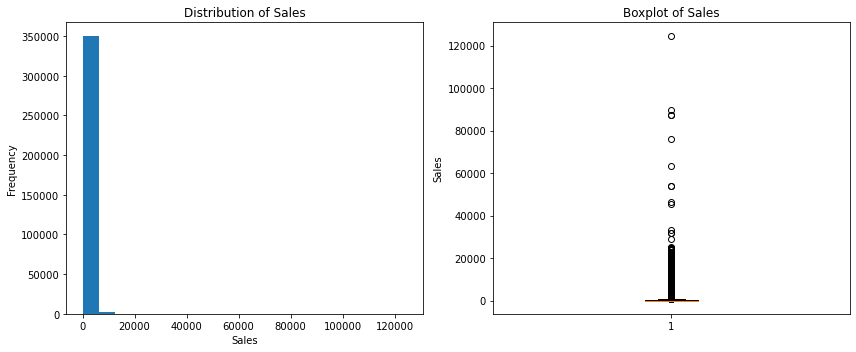

In [33]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(salesdata['sales'], bins=20)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Sales')

# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(salesdata['sales'])
ax2.set_ylabel('Sales')
ax2.set_title('Boxplot of Sales')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
    From our plots:<br><br>
        📌 Sales is positively skewed. <br> <br>
        📌 The median value is thus closer to the first quartile. <br><br>
        📌 The boxplot shows presence of very extreme values. <br><br>        
        📌 There is a high range between the values.
    </h4>
</div>


#### **Transactions column**



In [34]:
'''# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(salesdata['transactions'], bins=20)
ax1.set_xlabel('transactions')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of transactions')
plt.grid(False)


# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(salesdata['transactions'])
ax2.set_ylabel('transactions')
ax2.set_title('Boxplot of transactions')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.grid(False)
plt.show()'''

"# Create a figure and two subplots side by side\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))\n\n# Plot the histogram on the first subplot (ax1)\nax1.hist(salesdata['transactions'], bins=20)\nax1.set_xlabel('transactions')\nax1.set_ylabel('Frequency')\nax1.set_title('Distribution of transactions')\nplt.grid(False)\n\n\n# Plot the boxplot on the second subplot (ax2)\nax2.boxplot(salesdata['transactions'])\nax2.set_ylabel('transactions')\nax2.set_title('Boxplot of transactions')\n\n# Adjust layout to avoid overlapping labels\nplt.tight_layout()\n\n# Show the plots\nplt.grid(False)\nplt.show()"

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
    From the plots:<br>
        📌 The transactions are positively skewed.<br><br>
        📌 Transactions that fall within the interval of 500 - 1500 had the most occurance.<br><br>
        📌 This depicts pressence of outliers as confirmed by the boxplot.
</div>


#### **Oil Prices column column**



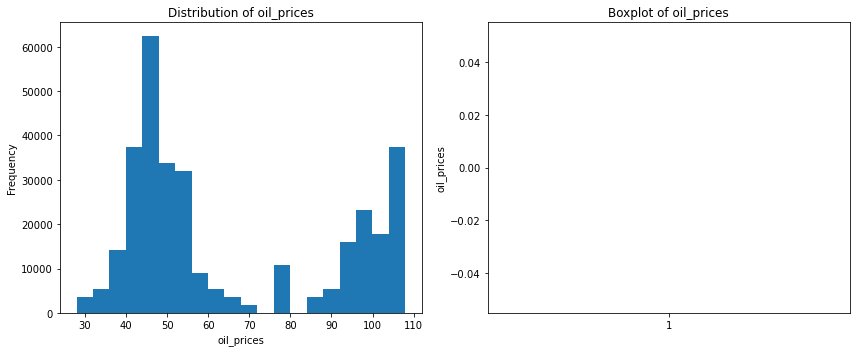

In [35]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(salesdata['oil_prices'], bins=20)
ax1.set_xlabel('oil_prices')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of oil_prices')
plt.grid(False)


# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(salesdata['oil_prices'])
ax2.set_ylabel('oil_prices')
ax2.set_title('Boxplot of oil_prices')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.grid(False)
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 The histogram displays a bimodal distribution characterized by two prominent peaks. <br><br>
        📌 The first peak is observed in the interval between 40 and 55, indicating a concentration of data points in this range. <br><br>
        📌 This suggests that a significant portion of the dataset falls within this range, leading to a higher frequency count within this interval.<br><br>
        📌 The second peak occurs in the interval between 98 and 100. <br><br>
        📌 This peak signifies another concentration of data points in this range, which is distinct from the first peak. <br><br>
        📌 The presence of two distinct peaks suggests the existence of two modes or clusters within the dataset.<br><br>
        📌 Maybe this phenomenon is due to the pressence of some missing data.
        
</div>



#### **Onpromotion column**



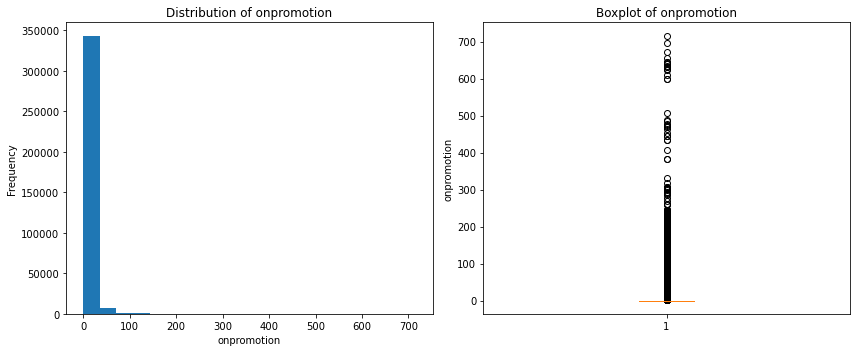

In [36]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(salesdata['onpromotion'], bins=20)
ax1.set_xlabel('onpromotion')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of onpromotion')
plt.grid(False)


# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(salesdata['onpromotion'])
ax2.set_ylabel('onpromotion')
ax2.set_title('Boxplot of onpromotion')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.grid(False)
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
    From our plots:<br><br>
        📌 onpromotion is positively skewed. <br> <br>
        📌 The median value is thus closer to the first quartile. <br><br>
        📌 The boxplot shows presence of very extreme values. <br><br>        
        📌 There is a high range between the values.
    </h4>
</div>

>### **4.2 Bivariate Data Analysis**
#### **Trend of Daily average sales**

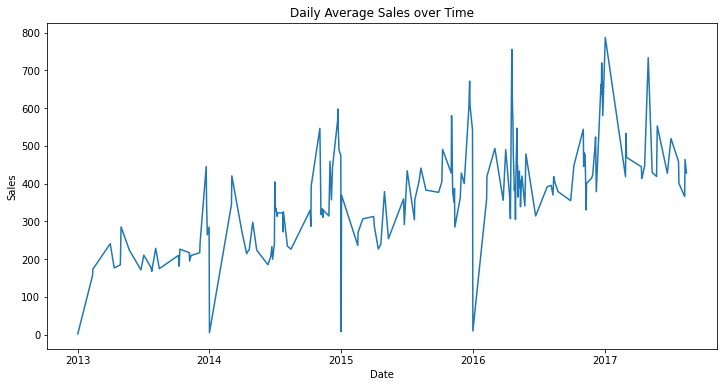

In [37]:
# Converting the 'date' column to datetime format
salesdata['date'] = pd.to_datetime(salesdata['date'])

# Grouping the sales data by date and calculating the mean sales for each day
salesdata_daily = salesdata.groupby('date')['sales'].mean()

# Creating a new figure for the plot with a specified size
plt.figure(figsize=(12, 6))

# Creating a line plot of daily average sales over time
plt.plot(salesdata_daily.index, salesdata_daily.values)

# Adding a label to the x-axis
plt.xlabel('Date')

# Adding a label to the y-axis
plt.ylabel('Sales')

# Adding a title to the plot
plt.title('Daily Average Sales over Time')

# Displaying the plot
plt.show()


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
    From our plot:<br><br>
        📌 Daily average sales exhibit an upward trend over the years, except from 2017. <br> <br>
        📌 There are some seasonal peaks in each year as well, especially at the end of each year. <br><br>        
    </h4>
</div>

### **Trend of Daily Average Oil Prices**



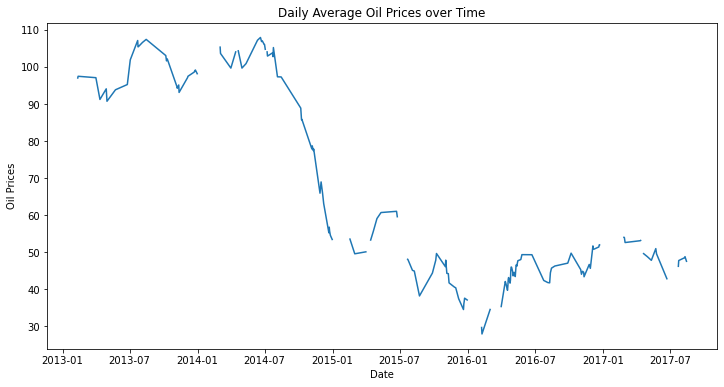

In [38]:
# Converting the 'date' column to datetime format
salesdata['date'] = pd.to_datetime(salesdata['date'])

# Grouping the data by date and calculating the mean oil prices for each day
salesdata_daily = salesdata.groupby('date')['oil_prices'].mean()

# Creating a new figure for the plot with a specified size
plt.figure(figsize=(12, 6))

# Creating a line plot of daily average oil prices over time
plt.plot(salesdata_daily.index, salesdata_daily.values)

# Adding a label to the x-axis
plt.xlabel('Date')

# Adding a label to the y-axis
plt.ylabel('Oil Prices')

# Adding a title to the plot
plt.title('Daily Average Oil Prices over Time')

# Displaying the plot
plt.show()


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
    From our plot:<br><br>
        📌 Trend in Oil Prices: <br>
        The data indicates that there was a notable decrease in oil prices from 2013 to 2015, with the price dropping significantly by more than half. This likely reflects the global decline in oil prices that occurred during this period.<br><br>
        📌 Stability and Recovery: <br>
        The oil prices seem to have stabilized and slightly recovered from 2016 to 2017. While they are still lower than the earlier years, the trend shows a moderate increase.<br><br>
        📌 Economic Factors:<br> 
        These fluctuations in oil prices might be attributed to various economic factors, including changes in supply and demand, geopolitical events, technological advancements in oil extraction, and global economic conditions.<br><br>
        📌 Impact on Various Sectors: <br>
        Fluctuations in oil prices can have significant impacts on various sectors, including energy, transportation, manufacturing, and more. Higher oil prices can lead to increased costs for businesses and consumers, while lower prices might stimulate economic activity.<br><br>
        📌 Year-to-Year Variability: <br>
        The significant variations in mean oil prices from year to year highlight the volatility of the oil market and how sensitive it is to global events and economic conditions. <br>
       📌 Also earlier we saw there was missing values in oil prices, they will be interpolated using backward fill.      
    </h4>
</div>

In [39]:
# Interpolate missing values using backward fill 

salesdata['oil_prices'].fillna(method='bfill', inplace=True)

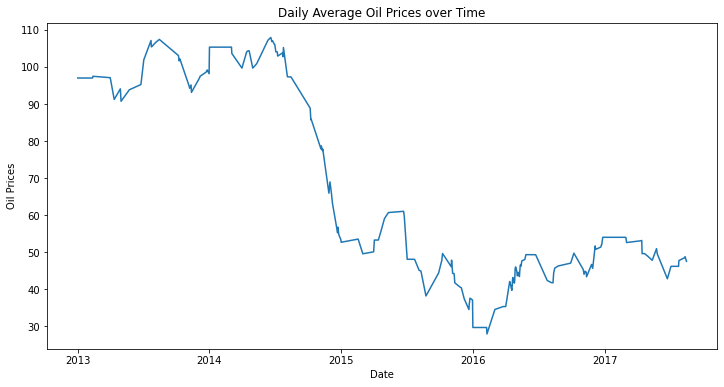

In [40]:
#Visualizating the backward fill
# Converting the 'date' column to datetime format
salesdata['date'] = pd.to_datetime(salesdata['date'])

# Grouping the data by date and calculating the mean oil prices for each day
salesdata_daily = salesdata.groupby('date')['oil_prices'].mean()

# Creating a new figure for the plot with a specified size
plt.figure(figsize=(12, 6))

# Creating a line plot of daily average oil prices over time
plt.plot(salesdata_daily.index, salesdata_daily.values)

# Adding a label to the x-axis
plt.xlabel('Date')

# Adding a label to the y-axis
plt.ylabel('Oil Prices')

# Adding a title to the plot
plt.title('Daily Average Oil Prices over Time')

# Displaying the plot
plt.show()


#### **Sales against holiday type**



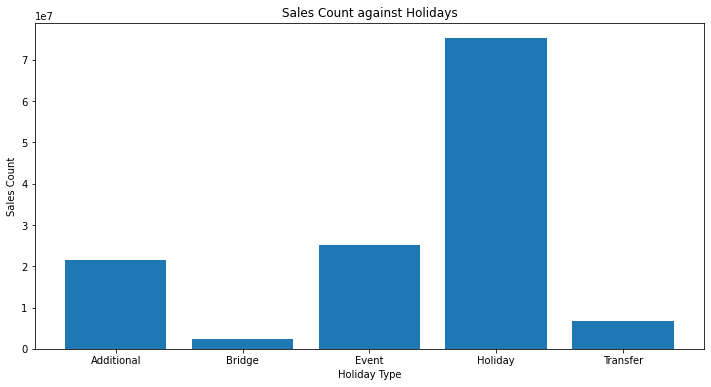

In [41]:
# Converting the 'date' column to datetime format
salesdata['date'] = pd.to_datetime(salesdata['date'])

# Grouping the sales data by holiday type and calculating the sum of sales for each holiday type
salesdata_daily = salesdata.groupby('holiday_type')['sales'].sum()

# Creating a new figure for the plot with a specified size
plt.figure(figsize=(12, 6))

# Creating a bar plot of sales count against holiday types
plt.bar(salesdata_daily.index, salesdata_daily.values)

# Adding a label to the x-axis
plt.xlabel('Holiday Type')

# Adding a label to the y-axis
plt.ylabel('Sales Count')

# Adding a title to the plot
plt.title('Sales Count against Holidays')

# Displaying the plot
plt.show()


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
    From our plot:<br><br>
        📌 Sales Distribution: <br>
        The data indicates how sales are distributed across different holiday types. Some holiday types, like 'Holiday' and 'Event,' have significantly higher sales counts compared to others.<br><br>
        📌 Impact of Holidays: <br>
        It's evident that holidays, whether they are 'Additional,' 'Event,' or traditional 'Holiday' types, contribute significantly to sales. 'Event' and 'Holiday' holidays, in particular, seem to have a substantial impact on sales.<br><br>
        📌 Variation in Sales:<br> 
        The variation in sales counts across different holiday types suggests that some holidays are more commercially impactful than others. This could be due to various factors, such as increased consumer spending during certain holiday periods or specific sales promotions associated with particular holiday types.<br><br>
        📌 Seasonal Trends: <br>
        Understanding how different holiday types contribute to sales can also reveal seasonal trends and patterns in consumer behavior. These insights can guide inventory management and staffing decisions.<br><br>               
    </h4>
</div>

#### **Sales against store number**



Text(0.5, 1.0, 'Top 10 Sales Count against Store Number')

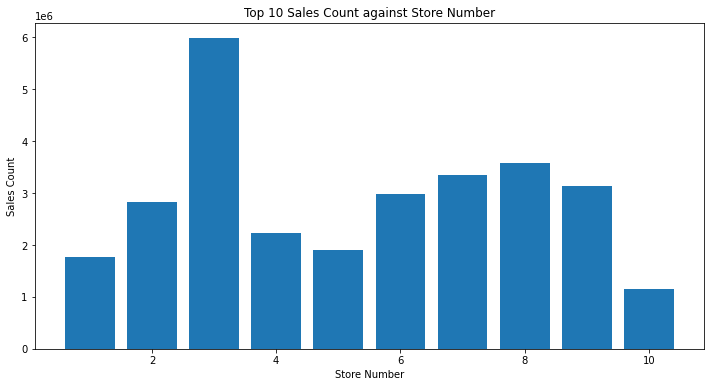

In [42]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('store_number')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (12,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Store Number')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against Store Number')


Text(0.5, 1.0, 'Bottom 10 Sales Count against Store Number')

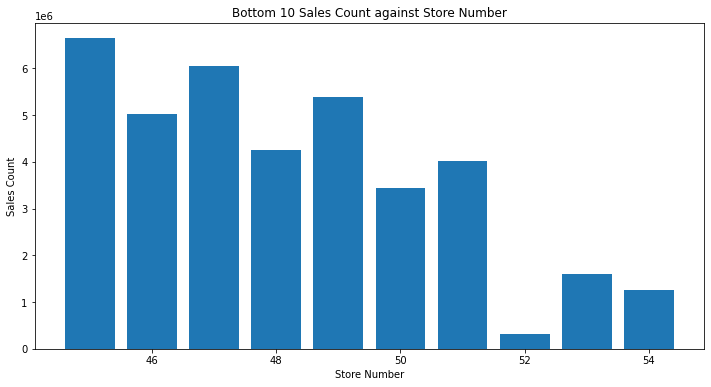

In [43]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('store_number')['sales'].sum().tail(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (12,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Store Number')
plt.ylabel('Sales Count')
plt.title('Bottom 10 Sales Count against Store Number')


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 After displaying both the top 10 and bottom 10 most store salers the highest store seller was store number 3 and the bottom store seller being store number 52.
</div>


#### **Sales against Product**

Text(0.5, 1.0, 'Top 10 Sales Count against Product Sold')

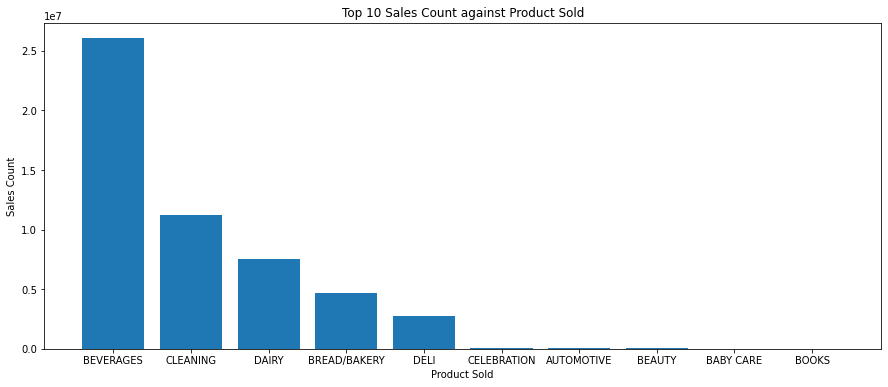

In [44]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('family')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Product Sold')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against Product Sold')


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 After displaying the top 10 product with most sales beverages were the leading products followed by cleaning products
</div>


#### **Sales against State**

Text(0.5, 1.0, 'Top 10 Sales Count against State')

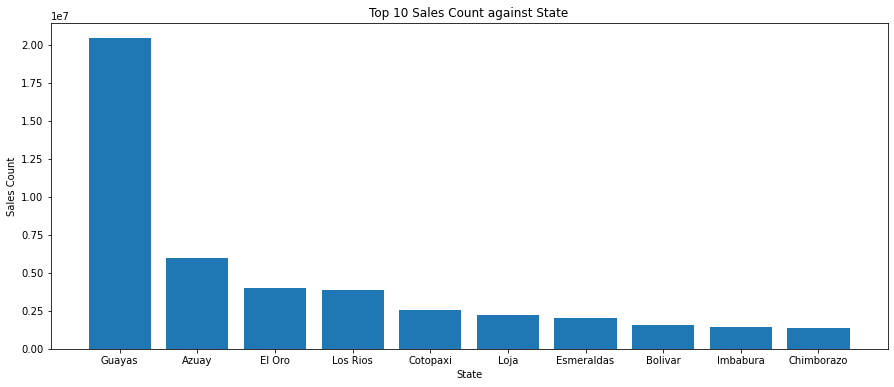

In [45]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('state')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('State')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against State')


Text(0.5, 1.0, 'Sales Count in Various series in Guayas')

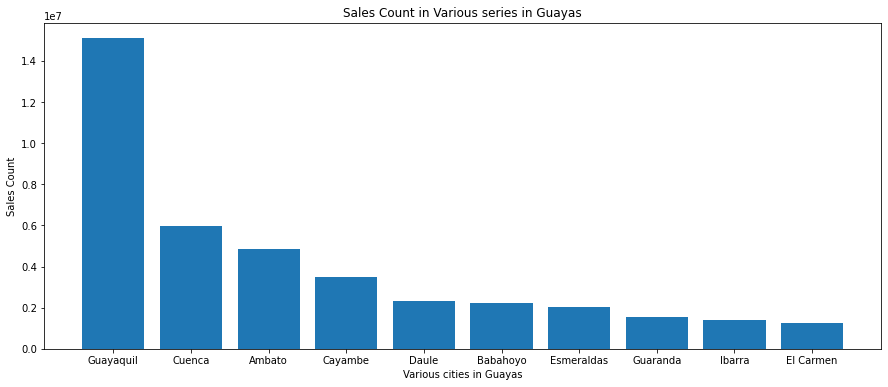

In [46]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata[salesdata['state']=='Guayas']
salesdata_daily=salesdata.groupby('city')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Various cities in Guayas')
plt.ylabel('Sales Count')
plt.title('Sales Count in Various series in Guayas')



<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 Most sales where recorded in the state of Guayas. Given the state of Guayas the highest city with most sales in Guayas is Guayaquil
</div>


#### **Sales against type**

Text(0.5, 1.0, 'Top 10 Sales Count against State')

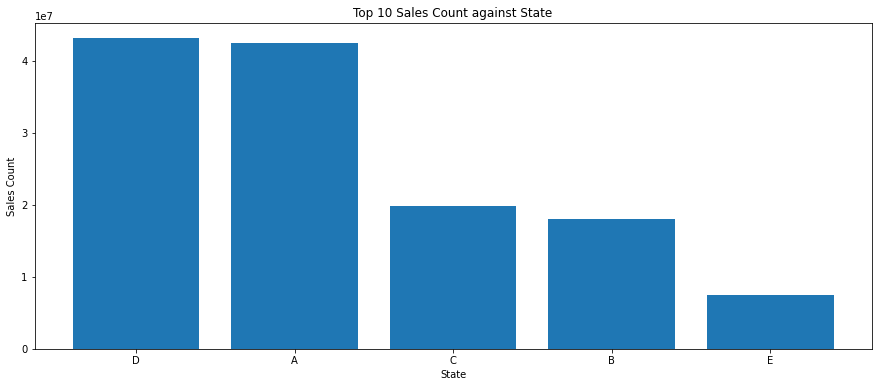

In [47]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('type')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('State')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against State')


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 Most sales where related to product of type D and the least of product type E
</div>


>### **4.3 Time Series Analysis of sales by resampling**
We visualize the time series of sales across time

In [48]:
# Choose date and sales columns
timeseriesdata=salesdata[['sales','date']]
timeseriesdata.index = timeseriesdata['date']
timeseriesdata
# make date the index
del timeseriesdata['date']
timeseriesdata



,sales
date,
2013-01-01,0.000
2013-01-01,0.000
2013-01-01,0.000
2013-01-01,0.000
2013-01-01,0.000
...,...
2017-08-15,438.133
2017-08-15,154.553
2017-08-15,2419.729


#### **Yearly Series of Total Sales**

In [49]:
sales_per_year= timeseriesdata.resample('Y').sum()
plt.figure(figsize= (15,6))
sns.lineplot(sales_per_year)
plt.ylabel('Sales')


ValueError: If using all scalar values, you must pass an index

<Figure size 1080x432 with 0 Axes>

>### **Analyzing monthly sales across each year**

In [50]:
timeseriesdata= timeseriesdata.resample('M').sum()


>#### **4.3.1. Year 2013**

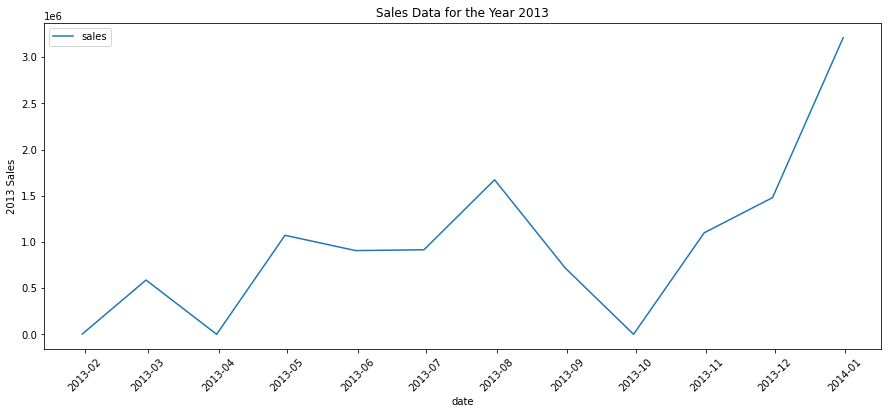

In [51]:
data2013 = timeseriesdata[timeseriesdata.index.year == 2013]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2013)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2013 Sales')
plt.title('Sales Data for the Year 2013')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>#### **4.3.2. Year 2014**

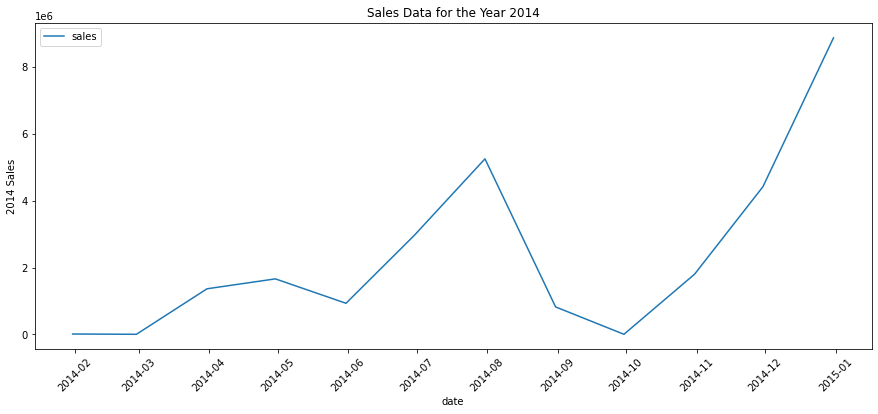

In [52]:
data2014 = timeseriesdata[timeseriesdata.index.year == 2014]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2014)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2014 Sales')
plt.title('Sales Data for the Year 2014')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>#### **4.3.3. Year 2015**

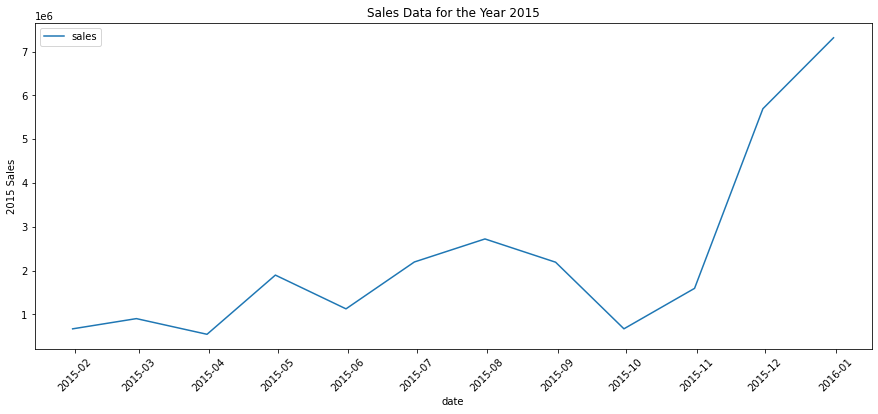

In [53]:
data2015 = timeseriesdata[timeseriesdata.index.year == 2015]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2015)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2015 Sales')
plt.title('Sales Data for the Year 2015')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>#### **4.3.4. Year 2016**

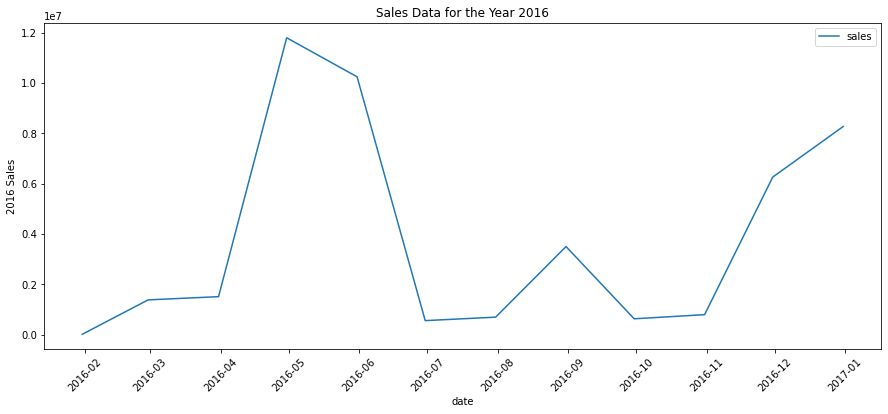

In [54]:
data2016 = timeseriesdata[timeseriesdata.index.year == 2016]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2016)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2016 Sales')
plt.title('Sales Data for the Year 2016')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>#### **4.3.5. Year 2017**

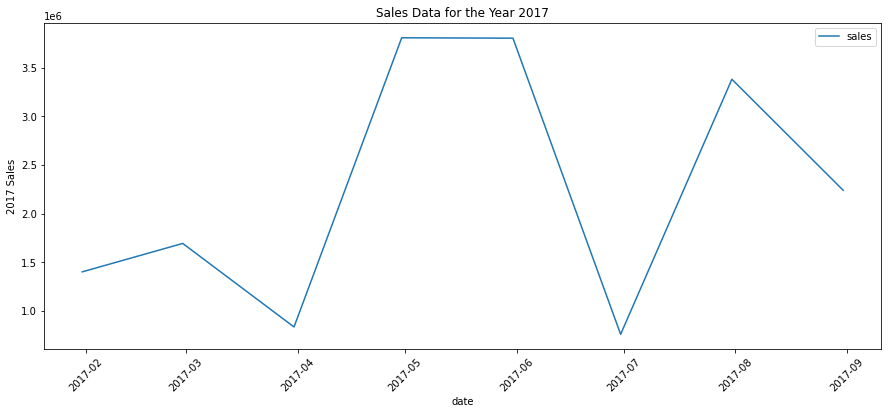

In [55]:
data2017 = timeseriesdata[timeseriesdata.index.year == 2017]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2017)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2017 Sales')
plt.title('Sales Data for the Year 2017')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>### **Sales series across months**

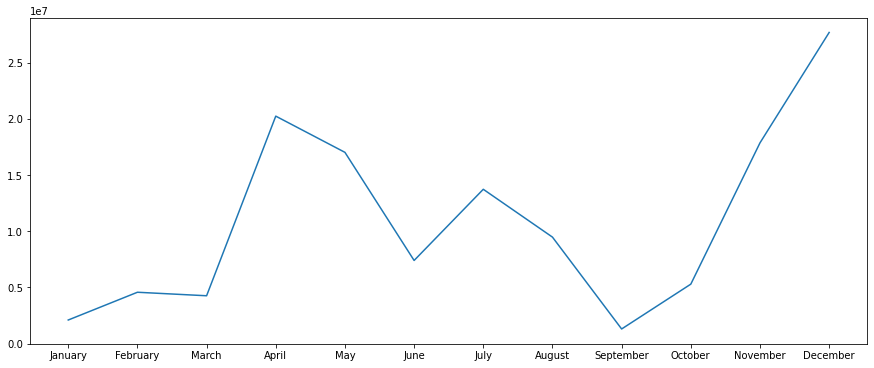

In [56]:

# Group by month and calculate the sum of sales
monthly_sales = salesdata.groupby(salesdata['date'].dt.strftime('%B'))['sales'].sum()
# List of month names in order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Convert month names to categorical with specified order
monthly_sales.index = pd.Categorical(monthly_sales.index, categories=month_order, ordered=True)
# Sort the index to order the months
monthly_sales = monthly_sales.sort_index()
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
plt.plot(monthly_sales)
plt.show()





<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        The sales start increasing from september but exponentionally increase from October to December and from March to April. The highest purchases where witnessed in December and the lowest in September.
    </h4>
</div>


>### **Sales Series in Date**


In [57]:
salesdata['date']=pd.to_datetime(salesdata['date'])
daily_sales = salesdata.groupby(salesdata['date'].dt.day)['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        The highest sales are recorded at the beginning and at the end of the month.
    </h4>
</div>


>### **4.4. MultiVariate Analysis**

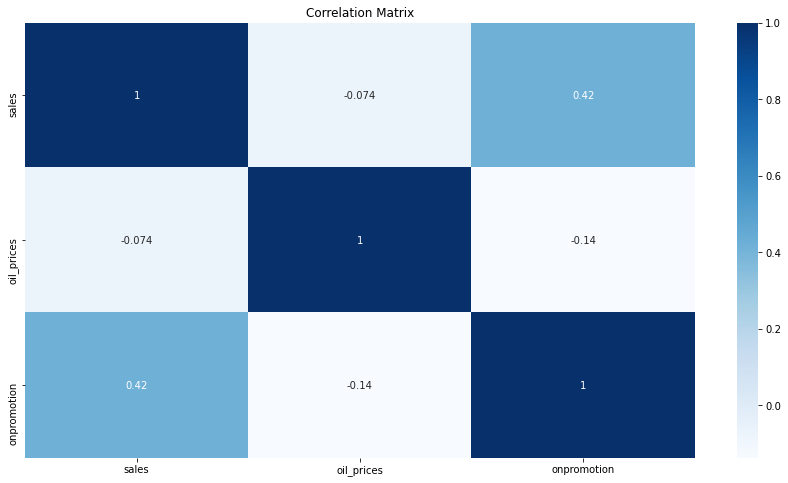

In [58]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales','oil_prices','onpromotion']

# Compute correlation matrix
corr_matrix = salesdata[numerical_vars].corr()

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        There is a significant positive relationship between number of items on promotion with slaes as well as a weak negative relation with oil and sales.
    </h4>
</div>


### Answering some of the questions
* **Is the dataset complete?**

In [59]:
# Check the completeness of the train dataset
min_date = salesdata['date'].min()
max_date = salesdata['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(salesdata['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11',
               ...
               '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06',
               '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-12',
               '2017-08-13', '2017-08-14'],
              dtype='datetime64[ns]', length=1508, freq=None)


The train dataset is not complete for all required dates. There are missing dates spanning from January 2, 2013, to August 14, 2017, totaling 1508 missing dates. This means that there are gaps in the dataset, and it does not contain records for these specific dates.

These missing dates could be of significance as the project is to analyze sales data over a continuous time period. Based on our project goals, we need to consider how to handle these gaps in the data, such as through data imputation or by excluding these missing dates from our analysis to ensure that we are working with a complete and continuous time series.

Such decision will be taken during the preprocessing stage of our analysis
<br>



* **Did the earthquake impact sales?**<br>
The 2016 Ecuador earthquake occurred on April 16  with a moment magnitude of 7.8  

In [60]:
# Filter sales data for the periods before and after the earthquake
sales_before_earthquake = salesdata[salesdata['date'] < '2016-04-16']
sales_after_earthquake = salesdata[salesdata['date'] >= '2016-04-16']

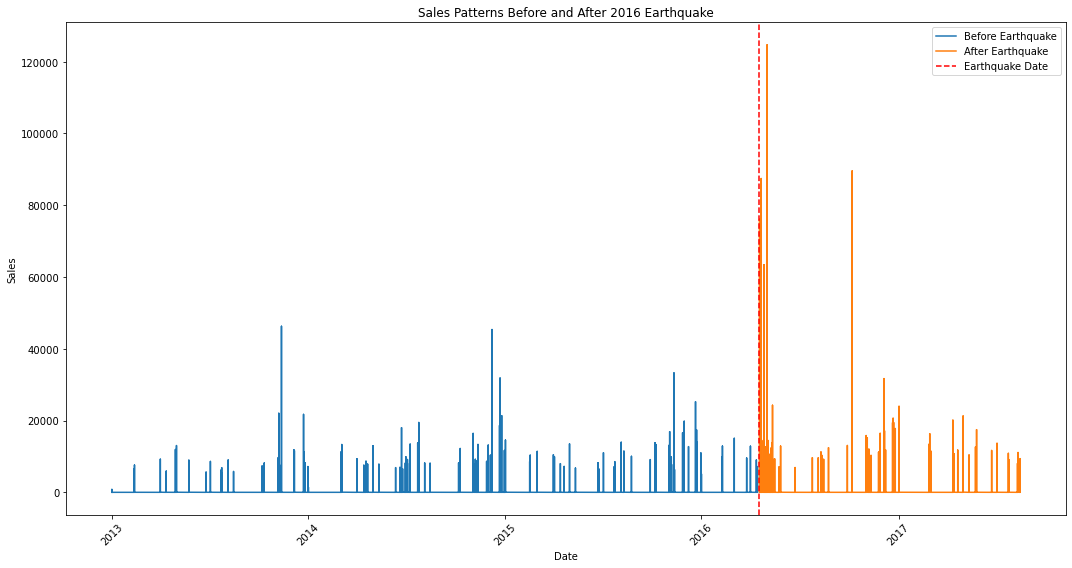

In [61]:
# Create a line plot for sales trends before and after the earthquake
plt.figure(figsize=(15,8))
plt.plot(sales_before_earthquake['date'], sales_before_earthquake['sales'], label='Before Earthquake')
plt.plot(sales_after_earthquake['date'], sales_after_earthquake['sales'], label='After Earthquake')
plt.axvline(x=pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='Earthquake Date')
plt.title('Sales Patterns Before and After 2016 Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Before the earthquake**: Sales appear to follow a relatively stable pattern before the earthquake, with some fluctuations but no major disruptions. There is a consistent trend, and sales remain within a certain range.

**After the earthquake** : The sales data showed some noticeable changes in sales patterns after the 2016 earthquake. Sales patterns changed significantly after the 2016 earthquake, with a noticeable spike in sales immediately following the event. This observation indicates that the earthquake might have had a significant impact on consumer behavior and purchasing patterns.But a few months after the earthquake, sales seems to return to the original pattern

## **5. Testing Hypothesis**
Before hypothesis testing we explore the distribution of sales. Using shapiro wilk test to explore distribution.

In [62]:
# Group the data by 'Year Funded'
grouped_data = salesdata.groupby('date')['sales'].sum()
grouped_data
# Perform Shapiro-Wilk test for each group
statistic, p_value = stats.shapiro(grouped_data)
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic)
print("P-value:", p_value)
if p_value < 0.05:
    print("The data does not follow a normal distribution.")
else:
    print("The data follows a normal distribution.")

Shapiro-Wilk Test Results:
Statistic: 0.869274377822876
P-value: 2.2158753998358094e-11
The data does not follow a normal distribution.


The p-value is below 0.05 therefore, the sales do not follow normal distribution hence non parametric ANOVA will be used.

**Hypothesis 1: <br>**
```Null```: The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.<br>
```Alternate```: The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

In [63]:
 
#for this example we will use the Pearson Correlation.
alpha = 0.05
pearson_coef, p_value = stats.pearsonr(salesdata["sales"], salesdata["onpromotion"])
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", round(p_value,3) )
if p_value < alpha:
    print("Reject the null hypothesis. The promotional activities have a significant impact on store sales for Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis. The promotional activities dont have a significant impact on store sales for Corporation Favorita..")

Pearson Correlation Coefficient:  0.4218133614217935 and a P-value of: 0.0
Reject the null hypothesis. The promotional activities have a significant impact on store sales for Corporation Favorita.


In [64]:
def perform_anova(data_frame, column_name, value_column):
    groups = data_frame[column_name].unique()
    group_data = [data_frame.query(f'{column_name}=="{group}"')[value_column] for group in groups]
    fvalue, pvalue = stats.f_oneway(*group_data)
    return pvalue

# Assuming salesdata is your DataFrame containing the "sales" and "holiday_type" columns
p_value = perform_anova(salesdata, 'holiday_type', 'sales')

print("p_value:", round(p_value, 3))
if p_value < alpha:
    print("Reject the null hypothesis. The holidya_types have a significant impact on store sales for Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis. The holiday_types dont have a significant impact on store sales for Corporation Favorita..")


p_value: 0.0
Reject the null hypothesis. The holidya_types have a significant impact on store sales for Corporation Favorita.


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        Conclusion : The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.
    </h4>
</div>


**Hypothesis 2: <br>**
```Null```: Sales do not increase over time. <br>
```Alternate```: Sales increase with time.



In [65]:
## print each amount in each stage as a list and get the amount per stage as an array

amounts_per_year=salesdata.groupby("date")['sales'].apply(list)
amount_year = np.array(amounts_per_year)

# Perform one-way ANOVA
test_statistic, p_value = stats.kruskal(*amount_year)
print(f"P_value: {p_value}")


# Interpret the results
if p_value < alpha:
    print("Reject the null hypothesis concluding that sales increase with time.")
else:
    print("Fail to reject the null hypothesis concluding that sales dont increase with time.")


P_value: 0.0
Reject the null hypothesis concluding that sales increase with time.


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        Conclusion : The sales increase over time for Corporation Favorita.
    </h4>
</div>


**Hypothesis 3: <br>**
```Null```: Situating a startup in a particular city does not influence sales.<br>
```Alternate```: Situating a startup in a particular city significantly affects sales.



In [66]:
def perform_anova(data_frame, column_name, value_column):
    groups = data_frame[column_name].unique()
    group_data = [data_frame.query(f'{column_name}=="{group}"')[value_column] for group in groups]
    fvalue, pvalue = stats.f_oneway(*group_data)
    return pvalue

# Assuming salesdata is your DataFrame containing the "sales" and "holiday_type" columns
p_value = perform_anova(salesdata, 'city', 'sales')

print("p_value:", round(p_value, 3))
if p_value < alpha:
    print("Reject the null hypothesis. Situating a startup in a particular city significantly affects sales.")
else:
    print("Fail to reject the null hypothesis. Situating a startup in a particular city does not influence sales")


p_value: 0.0
Reject the null hypothesis. Situating a startup in a particular city significantly affects sales.


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        Conclusion : Situating a startup in a particular city significantly affects sales.
    </h4>
</div>



### **Stationarity Test**

A stationary time series is a series whose statistical properties are independent of the point in time at which they are observed. A stationary time series has a constant variance and it always returns to the long-run mean

**Ways to check stationarity**<br>
 i. Visualisation using trends, irregularity and seasonality.<br>
ii. Statistical tests using unit root stationary tests. Unit root test determines how strongly a time series is defined by a trend using tests like:
* Augmented Dickey Fuller test (ADH Test)
* Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
* Autocorrelation Function(ACF) and Partial Autocorrelation Function(PACF) plots: If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.



> #### **6.1 Augumented Dickey Fuller Test(ADH Test) on Sales column**

In [74]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(salesdata['sales'])  

# Print the test result
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpret the results
if result[1] < 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")


ADF Statistic: -37.53268884227349
p-value: 0.0
Critical Values: {'1%': -3.430368538613456, '5%': -2.861548193841401, '10%': -2.566774361283781}
The time series is likely stationary.


> ### **6.2 Autocorrelation tests**

> #### The ACF measures the correlation between your data and its lagged values, while the PACF measures the correlation between your data and its lagged values after removing the effect of other lags. If your data is stationary, the ACF and PACF should decay quickly to zero, or show a periodic pattern if there is seasonality.

<Figure size 1440x1080 with 0 Axes>

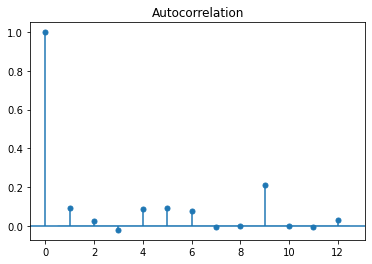

In [85]:
plt.figure(figsize=(20,15))
plot_acf(salesdata['sales'], lags= 12, alpha=0.05)
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        The ACF quickly decays to 0 thus iluustrating a stationary time series
    </h4>
</div>


<Figure size 1080x576 with 0 Axes>

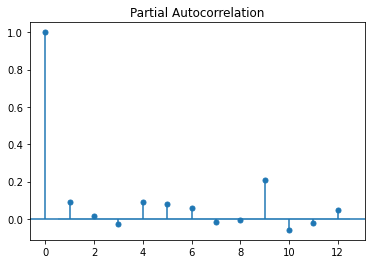

In [86]:
plt.figure(figsize=(15,8))
pacf = plot_pacf(salesdata['sales'],lags= 12, alpha=0.05)



## **7. Feature Scaling and Engineering**

* Date Time Features: these are components of the time step itself for each observation.<br>
* Lag Features: these are values at prior time steps.<br>
* Window Features: these are a summary of values over a fixed window of prior time steps.<br>

In [ ]:
#View the data
salesdata.head()

,id,date,store_number,transactions,family,sales,onpromotion,city,state,type,...,oil_prices,holiday_type,locale,locale_name,description,transferred,year,month,day,dayofweek_num
0,561,2013-01-01,25,770,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,...,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
1,562,2013-01-01,25,770,BABY CARE,0.0,0,Salinas,Santa Elena,D,...,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
2,563,2013-01-01,25,770,BEAUTY,2.0,0,Salinas,Santa Elena,D,...,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
3,564,2013-01-01,25,770,BEVERAGES,810.0,0,Salinas,Santa Elena,D,...,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
4,565,2013-01-01,25,770,BOOKS,0.0,0,Salinas,Santa Elena,D,...,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1


In [ ]:
#Dropping the id column
salesdata.drop(columns='id',axis=1)
salesdata

,id,date,store_number,transactions,family,sales,onpromotion,city,state,type,...,oil_prices,holiday_type,locale,locale_name,description,transferred,year,month,day,dayofweek_num
0,561,2013-01-01,25,770,AUTOMOTIVE,0.00000,0,Salinas,Santa Elena,D,...,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
1,562,2013-01-01,25,770,BABY CARE,0.00000,0,Salinas,Santa Elena,D,...,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
2,563,2013-01-01,25,770,BEAUTY,2.00000,0,Salinas,Santa Elena,D,...,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
3,564,2013-01-01,25,770,BEVERAGES,810.00000,0,Salinas,Santa Elena,D,...,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
4,565,2013-01-01,25,770,BOOKS,0.00000,0,Salinas,Santa Elena,D,...,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322042,2445394,2016-10-07,22,700,POULTRY,253.38101,11,Puyo,Pastaza,C,...,49.759998,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False,2016,10,7,4
322043,2445395,2016-10-07,22,700,PREPARED FOODS,43.00000,1,Puyo,Pastaza,C,...,49.759998,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False,2016,10,7,4
322044,2445396,2016-10-07,22,700,PRODUCE,281.20200,1,Puyo,Pastaza,C,...,49.759998,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False,2016,10,7,4
322045,2445397,2016-10-07,22,700,SCHOOL AND OFFICE SUPPLIES,0.00000,0,Puyo,Pastaza,C,...,49.759998,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False,2016,10,7,4


### **Modelling**


In [99]:
time_series= salesdata.drop(columns=['id','store_number', 'family', 'onpromotion', 'city', 'state', 'type', 'cluster', 'oil_prices', 'holiday_type', 'locale',
       'locale_name', 'description', 'transferred'])
time_series= time_series.set_index("date")
time_series.sample(6)

,sales
date,
2017-05-24,1570.000
2014-11-11,21.000
2017-05-12,707.848
2016-11-04,43.000
2013-04-01,234.000
2016-09-28,84.000


In [101]:
train, eval_set= train_test_split(time_series, test_size= 0.20,random_state=42)

In [120]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352836 entries, 2013-01-01 to 2017-08-15
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   sales   352836 non-null  float64
dtypes: float64(1)
memory usage: 5.4 MB


In [130]:
## Determining the Optimal Arima model for the train data
from pmdarima import auto_arima
sarima_model = pm.auto_arima(time_series, 
                             m=12,
                             seasonal=True,
                             start_p=0,
                             start_q=0,
                             start_P=0,
                             start_Q=0,
                             max_order=6, 
                             test='adf',
                             error_action='warn',  
                             suppress_warnings=True,
                              stepwise=True,
                              trace=False)





##basically, we are telling autoarima to perform a grid-cv kinda search to find the best parameters

##stepwise = true means the model will systematically take a look at each p,d,q values set to choose the best pdq combo based on AIC

## we choose the max p,d,q per information from our pACF and ACF plot

##result

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [132]:
time_series

,sales
date,
2013-01-01,0.000
2013-01-01,0.000
2013-01-01,0.000
2013-01-01,0.000
2013-01-01,0.000
...,...
2017-08-15,438.133
2017-08-15,154.553
2017-08-15,2419.729


In [123]:
from statsmodels.tsa.arima.model import ARIMA

model_2 = ARIMA(time_series, order=(1,1,0))

model_2.summary()

AttributeError: 'ARIMA' object has no attribute 'summary'

In [125]:
#fit our AR model
model= AutoReg(time_series, lags=10).fit()

NameError: name 'AutoReg' is not defined

In [126]:
stepwise_fit=auto_arima(sales_data["sales"],trace=True,suppress_warnings=True)
stepwise_fit.summary()

NameError: name 'auto_arima' is not defined